In [1]:
# FROM GAN_stability https://github.com/LMescheder/GAN_stability/blob/master/gan_training/config.py

import yaml
from torch import optim
from os import path

# General config
def load_config(path, default_path):
    ''' Loads config file.
    Args:  
        path (str): path to config file
        default_path (bool): whether to use default path
    '''
    # Load configuration from file itself
    with open(path, 'r') as f:
        # cfg_special = yaml.load(f)
        cfg_special = yaml.safe_load(f)

    # Check if we should inherit from a config
    inherit_from = cfg_special.get('inherit_from')

    # If yes, load this config first as default
    # If no, use the default_path
    if inherit_from is not None:
        cfg = load_config(inherit_from, default_path)
    elif default_path is not None:
        with open(default_path, 'r') as f:
            # cfg = yaml.load(f)
            cfg = yaml.safe_load(f)
    else:
        cfg = dict()

    # Include main configuration
    update_recursive(cfg, cfg_special)

    return cfg


def update_recursive(dict1, dict2):
    ''' Update two config dictionaries recursively.
    Args:
        dict1 (dict): first dictionary to be updated
        dict2 (dict): second dictionary which entries should be used
    '''
    for k, v in dict2.items():
        # Add item if not yet in dict1
        if k not in dict1:
            dict1[k] = None
        # Update
        if isinstance(dict1[k], dict):
            update_recursive(dict1[k], v)
        else:
            dict1[k] = v

In [2]:
import glob
import numpy as np
from PIL import Image

from torchvision.datasets.vision import VisionDataset


class ImageDataset(VisionDataset):
    """
    Load images from multiple data directories.
    Folder structure: data_dir/filename.png
    """

    def __init__(self, data_dirs, transforms=None):
#         print("****************************")
#         print("INIT")
#         print("****************************")
        # Use multiple root folders
        if not isinstance(data_dirs, list):
            data_dirs = [data_dirs]

        # initialize base class
        VisionDataset.__init__(self, root=data_dirs, transform=transforms)

        self.filenames = []
        root = []
        # print(self.root)
        for ddir in self.root:
            filenames = self._get_files(ddir)
            self.filenames.extend(filenames)
            root.append(ddir)
#         print("FILENAMES")
        # print(self.filenames)
#         print("****************************")

    def __len__(self):
        return len(self.filenames)

    @staticmethod
    def _get_files(root_dir):
        return glob.glob(f'{root_dir}/*.png') + glob.glob(f'{root_dir}/*.jpg')

    def __getitem__(self, idx):
#         print("************************")
#         print("GET_ITEM")
        filename = self.filenames[idx]
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
#         print("************************")
        return img


class DRR(ImageDataset):
    def __init__(self, *args, **kwargs):
        super(DRR, self).__init__(*args, **kwargs)


class Carla(ImageDataset):
    def __init__(self, *args, **kwargs):
        super(Carla, self).__init__(*args, **kwargs)


class CelebA(ImageDataset):
    def __init__(self, *args, **kwargs):
        super(CelebA, self).__init__(*args, **kwargs)


class CUB(ImageDataset):
    def __init__(self, *args, **kwargs):
        super(CUB, self).__init__(*args, **kwargs)
        

class Cats(ImageDataset):
    def __init__(self, *args, **kwargs):
      super(Cats, self).__init__(*args, **kwargs)
    
    @staticmethod
    def _get_files(root_dir):
      return glob.glob(f'{root_dir}/CAT_*/*.jpg')


class CelebAHQ(ImageDataset):
    def __init__(self, *args, **kwargs):
        super(CelebAHQ, self).__init__(*args, **kwargs)
    
    def _get_files(self, root):
        return glob.glob(f'{root}/*.npy')
    
    def __getitem__(self, idx):
        img = np.load(self.filenames[idx]).squeeze(0).transpose(1,2,0)
        if img.dtype == np.uint8:
            pass
        elif img.dtype == np.float32:
            img = (img * 255).astype(np.uint8)
        else:
            raise NotImplementedError
        img = Image.fromarray(img).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        return img

In [3]:
import numpy as np
import torch
import imageio
import os
import glob
from torch.utils import data
from torch.utils.data import Dataset
from PIL import Image


class  ImageFolder(Dataset):
    """docstring for ArtDataset"""
    def __init__(self, root, transform=None):
        super( ImageFolder, self).__init__()
        self.root = root

        self.frame = self._parse_frame()
        self.transform = transform

    def _parse_frame(self):
        frame = []
        folders = glob.glob(os.path.join(self.root, '*'))
        for folder in folders:
            for f in glob.glob(os.path.join(folder, '*.png')):
                frame.append(f)
        return frame

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        file = self.frame[idx]
        img = Image.open(file).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img

def InfiniteSampler(n):
    """Data sampler"""
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0

class InfiniteSamplerWrapper(data.sampler.Sampler):
    """Data sampler wrapper"""
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 15

def get_nsamples(data_loader, N):
  x = []
  n = 0
  while n < N:
    x_next = next(data_loader)
    x_next = x_next.cuda(non_blocking=True)
    x.append(x_next)
    n += x_next.size(0)
  x = torch.cat(x, dim=0)[:N]
  return x


def count_trainable_parameters(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  return sum([np.prod(p.size()) for p in model_parameters])


def save_video(imgs, fname, as_gif=False, fps=24, quality=8):
    # convert to np.uint8
    imgs = (255 * np.clip(imgs.permute(0, 2, 3, 1).detach().cpu().numpy() / 2 + 0.5, 0, 1)).astype(np.uint8)
    imageio.mimwrite(fname, imgs, fps=fps, quality=quality)
    
    if as_gif:  # save as gif, too
        os.system(f'ffmpeg -i {fname} -r 15 '
                  f'-vf "scale=512:-1,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" {os.path.splitext(fname)[0] + ".gif"}')


def color_depth_map(depths, scale=None):
    """
    Color an input depth map.
    Arguments:
        depths -- HxW numpy array of depths
        [scale=None] -- scaling the values (defaults to the maximum depth)
    Returns:
        colored_depths -- HxWx3 numpy array visualizing the depths
    """

    _color_map_depths = np.array([
      [0, 0, 0],  # 0.000
      [0, 0, 255],  # 0.114
      [255, 0, 0],  # 0.299
      [255, 0, 255],  # 0.413
      [0, 255, 0],  # 0.587
      [0, 255, 255],  # 0.701
      [255, 255, 0],  # 0.886
      [255, 255, 255],  # 1.000
      [255, 255, 255],  # 1.000
    ]).astype(float)
    _color_map_bincenters = np.array([
      0.0,
      0.114,
      0.299,
      0.413,
      0.587,
      0.701,
      0.886,
      1.000,
      2.000,  # doesn't make a difference, just strictly higher than 1
    ])
  
    if scale is None:
      scale = depths.max()
  
    values = np.clip(depths.flatten() / scale, 0, 1)
    # for each value, figure out where they fit in in the bincenters: what is the last bincenter smaller than this value?
    lower_bin = ((values.reshape(-1, 1) >= _color_map_bincenters.reshape(1, -1)) * np.arange(0, 9)).max(axis=1)
    lower_bin_value = _color_map_bincenters[lower_bin]
    higher_bin_value = _color_map_bincenters[lower_bin + 1]
    alphas = (values - lower_bin_value) / (higher_bin_value - lower_bin_value)
    colors = _color_map_depths[lower_bin] * (1 - alphas).reshape(-1, 1) + _color_map_depths[
      lower_bin + 1] * alphas.reshape(-1, 1)
    return colors.reshape(depths.shape[0], depths.shape[1], 3).astype(np.uint8)


# Virtual camera utils


def to_sphere(u, v):
    theta = 2 * np.pi * u
    phi = np.arccos(1 - 2 * v)
    cx = np.sin(phi) * np.cos(theta)
    cy = np.sin(phi) * np.sin(theta)
    cz = np.cos(phi)
    s = np.stack([cx, cy, cz])
    return s


def polar_to_cartesian(r, theta, phi, deg=True):
    if deg:
        phi = phi * np.pi / 180
        theta = theta * np.pi / 180
    cx = np.sin(phi) * np.cos(theta)
    cy = np.sin(phi) * np.sin(theta)
    cz = np.cos(phi)
    return r * np.stack([cx, cy, cz])


def to_uv(loc):
    # normalize to unit sphere
    loc = loc / loc.norm(dim=1, keepdim=True)

    cx, cy, cz = loc.t()
    v = (1 - cz) / 2

    phi = torch.acos(cz)
    sin_phi = torch.sin(phi)

    # ensure we do not divide by zero
    eps = 1e-8
    sin_phi[sin_phi.abs() < eps] = eps

    theta = torch.acos(cx / sin_phi)

    # check for sign of phi
    cx_rec = sin_phi * torch.cos(theta)
    if not np.isclose(cx.numpy(), cx_rec.numpy(), atol=1e-5).all():
        sin_phi = -sin_phi

    # check for sign of theta
    cy_rec = sin_phi * torch.sin(theta)
    if not np.isclose(cy.numpy(), cy_rec.numpy(), atol=1e-5).all():
        theta = -theta

    u = theta / (2 * np.pi)
    assert np.isclose(to_sphere(u, v).detach().cpu().numpy(), loc.t().detach().cpu().numpy(), atol=1e-5).all()

    return u, v


def to_phi(u):
    return 360 * u  # 2*pi*u*180/pi


def to_theta(v):
    return np.arccos(1 - 2 * v) * 180. / np.pi


def sample_on_sphere(range_u=(0, 1), range_v=(0, 1)):
    u = np.random.uniform(*range_u)
    v = np.random.uniform(*range_v)
    return to_sphere(u, v)


def look_at(eye, at=np.array([0, 0, 0]), up=np.array([0, 0, 1]), eps=1e-5):
    at = at.astype(float).reshape(1, 3)
    up = up.astype(float).reshape(1, 3)

    eye = eye.reshape(-1, 3)
    up = up.repeat(eye.shape[0] // up.shape[0], axis=0)
    eps = np.array([eps]).reshape(1, 1).repeat(up.shape[0], axis=0)

    z_axis = eye - at
    z_axis /= np.max(np.stack([np.linalg.norm(z_axis, axis=1, keepdims=True), eps]))

    x_axis = np.cross(up, z_axis)
    x_axis /= np.max(np.stack([np.linalg.norm(x_axis, axis=1, keepdims=True), eps]))

    y_axis = np.cross(z_axis, x_axis)
    y_axis /= np.max(np.stack([np.linalg.norm(y_axis, axis=1, keepdims=True), eps]))

    r_mat = np.concatenate((x_axis.reshape(-1, 3, 1), y_axis.reshape(-1, 3, 1), z_axis.reshape(-1, 3, 1)), axis=2)

    return r_mat

In [47]:
import numpy as np
import torch
from torchvision.transforms import *

def save_config(outpath, config):
    from yaml import safe_dump
    with open(outpath, 'w') as f:
        safe_dump(config, f)


def update_config(config, unknown):
    # update config given args
    for idx,arg in enumerate(unknown):
        if arg.startswith("--"):
            if (':') in arg:
                k1,k2 = arg.replace("--","").split(':')
                argtype = type(config[k1][k2])
                if argtype == bool:
                    v = unknown[idx+1].lower() == 'true'
                else:
                    if config[k1][k2] is not None:
                        v = type(config[k1][k2])(unknown[idx+1])
                    else:
                        v = unknown[idx+1]
                print(f'Changing {k1}:{k2} ---- {config[k1][k2]} to {v}')
                config[k1][k2] = v
            else:
                k = arg.replace('--','')
                v = unknown[idx+1]
                argtype = type(config[k])
                print(f'Changing {k} ---- {config[k]} to {v}')
                config[k] = v

    return config


def get_data(config):
    H = W = imsize = config['data']['imsize']
    dset_type = config['data']['type']
    fov = config['data']['fov']

    transforms = Compose([
        Resize(imsize),
        ToTensor(),
        Lambda(lambda x: x * 2 - 1),
    ])

    kwargs = {
        'data_dirs': config['data']['datadir'],
        'transforms': transforms
    }

    if dset_type == 'carla':
        dset = Carla(**kwargs)

    elif dset_type == 'drr':
        dset = DRR(**kwargs)
        # print("DSET")
        # print(dset)

    elif dset_type == 'celebA':
        assert imsize <= 128, 'cropped GT data has lower resolution than imsize, consider using celebA_hq instead'
        transforms.transforms.insert(0, RandomHorizontalFlip())
        transforms.transforms.insert(0, CenterCrop(108))

        dset = CelebA(**kwargs)

    elif dset_type == 'celebA_hq':
        transforms.transforms.insert(0, RandomHorizontalFlip())
        transforms.transforms.insert(0, CenterCrop(650))

        dset = CelebAHQ(**kwargs)

    elif dset_type == 'cats':
      transforms.transforms.insert(0, RandomHorizontalFlip())
      dset = Cats(**kwargs)
  
    elif dset_type == 'cub':
        dset = CUB(**kwargs)

    dset.H = dset.W = imsize
    dset.focal = W/2 * 1 / np.tan((.5 * fov * np.pi/180.))
    radius = config['data']['radius']
    render_radius = radius
    if isinstance(radius, str):
        radius = tuple(float(r) for r in radius.split(','))
        render_radius = max(radius)
    dset.radius = radius

    # compute render poses
    N = 72
    num_volumes = 20
    theta = 0.5 * (to_theta(config['data']['vmin']) + to_theta(config['data']['vmax']))
    angle_range = (to_phi(config['data']['umin']), to_phi(config['data']['umax']))
    render_poses = get_render_poses(render_radius, num_volumes, angle_range=angle_range, theta=theta, N=N)

    print('Loaded {}'.format(dset_type), imsize, len(dset), render_poses.shape, [H,W,dset.focal,dset.radius], config['data']['datadir'])
    return dset, [H,W,dset.focal,dset.radius], render_poses


def get_render_poses(radius, num_volumes, angle_range=(0, 360), theta=0, N=40, swap_angles=False):
    poses = []
    theta = max(0.1, theta)
    for i in range(num_volumes):
        for angle in np.linspace(angle_range[0],angle_range[1],N+1)[:-1]:
            angle = max(0.1, angle)
            if swap_angles:
                loc = polar_to_cartesian(radius, theta, angle, deg=True)
            else:
                loc = polar_to_cartesian(radius, angle, theta, deg=True)
            R = look_at(loc)[0]
            RT = np.concatenate([R, loc.reshape(3, 1)], axis=1)
            # print(RT)
            # print(angle)
            newrow = [0, 0, 0, 1]
            RT = np.vstack([RT, newrow])
            poses.append(RT)
            # print(RT)
    return torch.from_numpy(np.stack(poses))

In [48]:
import os
from os import path

import sys

# Arguments
config = load_config("configs/chest.yaml", 'configs/default.yaml')
print(config['data'])

config['data']['fov'] = float(config['data']['fov'])
config = update_config(config, [])

out_dir = os.path.join(config['training']['outdir'], config['expname'])
checkpoint_dir = path.join(out_dir, 'chkpts')

# Create missing directories
if not path.exists(out_dir):
    os.makedirs(out_dir)
if not path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Save config file
save_config(os.path.join(out_dir, 'config.yaml'), config)

# Dataset
train_dataset, hwfr, render_poses = get_data(config)
# in case of orthographic projection replace focal length by far-near
# print("FAR")
# print(config['data']['far'])
# print("NEAR")
# print(config['data']['near'])
# print(config['data']['orthographic'])
print("FOCAL??")
focal_test = hwfr[2]
print(hwfr[2])
if config['data']['orthographic']:
    print("ORTHOGRAPHIC")
    hw_ortho = (config['data']['far']-config['data']['near'], config['data']['far']-config['data']['near'])
    hwfr[2] = hw_ortho
    print(hwfr[2])
    # print("**********************************")

config['data']['hwfr'] = hwfr  # add for building generator

print()

print("TRAIN_DATASET:")
print("-------------------------------------------------")
print(train_dataset)

print(type(train_dataset))

print()

print("HWFR:")
print("-------------------------------------------------")
print(hwfr)

print()

print("RENDER_POSES.SHAPE:")
print("-------------------------------------------------")
print(render_poses.shape)
# print(render_poses[0])

# print(train_dataset, hwfr, render_poses.shape)

{'datadir': '/scratch/gpfs/agp3/IW2022/chest_xrays', 'type': 'drr', 'imsize': 128, 'white_bkgd': False, 'near': 7.5, 'far': 12.5, 'radius': '9.5,10.5', 'fov': 10.0, 'orthographic': False, 'augmentation': True, 'umin': 0, 'umax': 1.0, 'vmin': 0.32898992833716556, 'vmax': 0.45642212862617093}
Loaded drr 128 1440 torch.Size([1440, 4, 4]) [128, 128, 731.523347376726, (9.5, 10.5)] /scratch/gpfs/agp3/IW2022/chest_xrays
FOCAL??
731.523347376726

TRAIN_DATASET:
-------------------------------------------------
Dataset DRR
    Number of datapoints: 1440
    Root location: ['/scratch/gpfs/agp3/IW2022/chest_xrays']
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Lambda()
           )
<class '__main__.DRR'>

HWFR:
-------------------------------------------------
[128, 128, 731.523347376726, (9.5, 10.5)]

RENDER_POSES.SHAPE:
-------------------------------------------------
tor

In [49]:
images = []
for i in range(1440):
    xray = train_dataset.__getitem__(i).transpose(2, 0).transpose(1, 0)
    images.append(xray)
images = torch.from_numpy(np.stack(images))

In [50]:
print(images.shape)
print(render_poses.shape)

torch.Size([1440, 128, 128, 3])
torch.Size([1440, 4, 4])


In [51]:
print(hw_ortho)

(5.0, 5.0)


In [52]:
from typing import Tuple
def get_rays(
  height: int,
  width: int,
  focal_length: float,
  c2w: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
  r"""
  Find origin and direction of rays through every pixel and camera origin.
  """

  # Apply pinhole camera model to gather directions at each pixel
  i, j = torch.meshgrid(
      torch.arange(width, dtype=torch.float32).to(c2w),
      torch.arange(height, dtype=torch.float32).to(c2w),
      indexing='ij')
  i, j = i.transpose(-1, -2), j.transpose(-1, -2)
  directions = torch.stack([torch.zeros_like(i),
                            torch.zeros_like(i),
                            -torch.ones_like(i)
                           ], dim=-1)

  offsets = torch.stack([(i - width * .5)/scale_ct_image ,
                         (j - height * .5)/scale_ct_image ,
                            torch.zeros_like(i)
                           ], dim=-1)

  # Apply camera pose to directions
  rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)

  # Origin is same for all directions (the optical center)
  rays_o = c2w[:3, -1].expand(rays_d.shape) + offsets
  return rays_o, rays_d

In [53]:
def get_rays_ortho(H, W, c2w, size_h, size_w):
    """Similar structure to 'get_rays' in submodules/nerf_pytorch/run_nerf_helpers.py"""
    # # Rotate ray directions from camera frame to the world frame
    rays_d = -c2w[:3, 2].view(1, 1, 3).expand(W, H, -1)  # direction to center in world coordinates

    i, j = torch.meshgrid(torch.linspace(0, W - 1, W),
                          torch.linspace(0, H - 1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()

    # Translation from center for origins
    rays_o = torch.stack([(i - W * .5), -(j - H * .5), torch.zeros_like(i)], -1)

    # Normalize to [-size_h/2, -size_w/2]
    rays_o = rays_o * torch.tensor([size_w / W, size_h / H, 1]).view(1, 1, 3)

    # Rotate origins to the world frame
    rays_o = torch.sum(rays_o[..., None, :] * c2w[:3, :3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]

    # Translate origins to the world frame
    rays_o = rays_o + c2w[:3, -1].view(1, 1, 3)

    return rays_o, rays_d

In [54]:
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange

# For repeatability
# seed = 3407
# torch.manual_seed(seed)
# np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [55]:
torch.__version__

'1.10.2+cu102'

In [56]:
print(images.shape[1:3])
print(hwfr[2])

torch.Size([128, 128])
731.523347376726


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images shape: torch.Size([1440, 128, 128, 3])
Poses shape: torch.Size([1440, 4, 4])
Focal length: 731.523347376726
Pose
tensor([[-1.7453e-03, -2.1644e-01,  9.7629e-01,  1.0251e+01],
        [ 1.0000e+00, -3.7776e-04,  1.7040e-03,  1.7892e-02],
        [ 0.0000e+00,  9.7630e-01,  2.1644e-01,  2.2726e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)


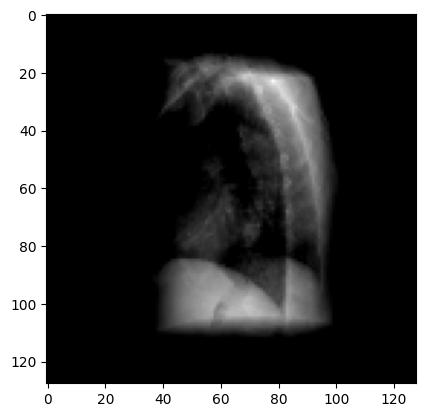

In [75]:
images = images
poses = render_poses
focal = focal_test # hwfr[2][0]

print(f'Images shape: {images.shape}')
print(f'Poses shape: {poses.shape}')
print(f'Focal length: {focal}')

height, width = hwfr[0], hwfr[1]
near, far = config['data']['near'], config['data']['far']

n_training = 71
testimg_idx = 72
testimg, testpose = images[testimg_idx], poses[testimg_idx]

plt.imshow(testimg)
print('Pose')
print(testpose)